In [134]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
import random
import json
MAX_GUESS_COUNT = 10

In [141]:
class AgentState(TypedDict):
    name: str
    counter: int
    guesses: list[int]
    lowerBound: int
    upperBound: int
    message: str
    hints: list[str]
    randomBound: list[dict]
    finalResult: str

In [224]:
def setup_node(state: AgentState) -> AgentState:
    """Node to inital setup of the AgentState"""

    state["message"] = f"Hi, {state.get('name', '')}, Welcome to guessing game"
    state["counter"] = 0
    state["lowerBound"] = state.get("lowerBound", 0)
    state["upperBound"] = state.get("upperBound", 10)
    state["guesses"] = []
    state["hints"] = []
    state["randomBound"] = []
    state["finalResult"] = "Lost agent was not able to guess the number, run out of chances"

    return state

def guess_node(state: AgentState) -> AgentState:
    """Node to perform the guessing operation on the lower and upper bound"""
    randomLowerBound = 1
    randomHigherBound = 10 ** 9

    if state.get("randomBound"):
        randomLowerBound = state["randomBound"][-1].get("randomLowerBound", 1)
        randomHigherBound = state["randomBound"][-1].get("randomHigherBound", 1000)


    # print(randomLowerBound, randomHigherBound)

    if state.get("hints", []):
        if state["hints"][-1] == "lower":
            randomHigherBound = randomHigherBound // 10
        elif state["hints"][-1] == "higher":
            randomLowerBound = randomLowerBound * 10 + 1

    if randomHigherBound <= randomLowerBound: randomHigherBound *= 2

    guessedNumber = random.randint(randomLowerBound, randomHigherBound)

    state["randomBound"].append({ "randomLowerBound": randomLowerBound, "randomHigherBound": randomHigherBound })
    state["guesses"].append(guessedNumber)
    state["counter"] += 1
    return state

def hint_node(state: AgentState) -> AgentState:
    """Node to provide the hint for the last guess"""

    hint = "lower"
    
    if state["lowerBound"] > state["guesses"][-1]:
        hint = "higher"
    elif state["lowerBound"] <= state["guesses"][-1] <= state["upperBound"]:
        state["finalResult"] = f"WON!! agent was able to guess the number in {state['counter']} chances"
        hint = "inBound"

    
    state["hints"].append(hint)

    return state

def hint_condition_edge(state: AgentState) -> AgentState:
    """Condition edge to decide whether to continue guessing or end the graph"""

    if state["hints"][-1] == "inBound" or state["counter"] >= MAX_GUESS_COUNT: return "exit"

    return "continue"

In [225]:
graph = StateGraph(AgentState)

graph.add_node("setup_node", setup_node)
graph.add_node("guess_node", guess_node)
graph.add_node("hint_node", hint_node)

graph.add_edge("setup_node", "guess_node")
graph.add_edge("guess_node", "hint_node")
graph.add_conditional_edges(
    "hint_node",
    hint_condition_edge,
    {
        "continue": "guess_node",
        "exit": END
    }
)

graph.set_entry_point("setup_node")

app = graph.compile()

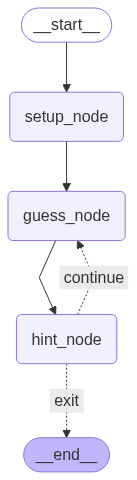

In [226]:
display(Image(app.get_graph().draw_mermaid_png()))

In [233]:
inputState = { "name": "DJ", "lowerBound": 1000, "upperBound": 2000 }
result = app.invoke(inputState)
print(result["finalResult"])
print(json.dumps(result["guesses"], indent=4))

if "Lost" in result["finalResult"]:
    print('*' * 10)
    print(json.dumps(result["randomBound"], indent=4))

WON!! agent was able to guess the number in 10 chances
[
    606675076,
    93811404,
    5262164,
    232857,
    16278,
    8211,
    441,
    957,
    644,
    1972
]
